In [99]:
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()


import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

mode = 'train'


In [100]:
num_epochs = 20 #5000
batch_size = 16
learning_rate = 4e-3 #1e-4
decay_rate = 1e-3 # 1e-1

latent_dim = 2*2*2
epsilon_mean = 1.0
epsilon_std = 1e-2

In [101]:
output = np.load("/Users/dongxiaofeng/Documents/GitHub/zeldo/Zeldotest.np.npy")
output = (output - output.min() )/(output.max() - output.min())

swe_train = output[0:800,:,:]
swe_valid = output[800:1000,:,:]

swe_train = swe_train.reshape(800,64,64,1)
swe_valid = swe_valid.reshape(200,64,64,1)

# # Visualize transformations
# plt.figure()
# plt.imshow(swe_train[0].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[1].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[2].reshape(64,64))
# plt.show()
# exit()

# Shuffle
swe_train_data = np.copy(swe_train)
swe_valid_data = np.copy(swe_valid)

np.random.shuffle(swe_train_data)
np.random.shuffle(swe_valid_data)


def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [102]:
print(swe_valid.shape)


(200, 64, 64, 1)


In [103]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
     Arguments
        args (tensor): mean and log of variance of Q(z|X)
     Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=epsilon_mean, stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [104]:
## Encoder
    
encoder_inputs = Input(shape=(64,64,1),name='Field')
# Encode   
x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(2,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Flatten()(x)
#x = Dense(32, activation='linear')(x)
x = Dense(16, activation='linear')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 64, 64, 30)   300         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 32, 32, 30)   0           conv2d_66[0][0]                  
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 32, 32, 25)   6775        max_pooling2d_30[0][0]           
____________________________________________________________________________________________

In [105]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#x = Dense(16, activation='linear')(latent_inputs)
#x = Dense(32, activation='linear')(x)
x = Dense(2*2*2, activation='linear')(latent_inputs)
x = Reshape((2, 2, 2))(x)

# decoder_inputs = Input(shape=(2,2,2),name='decoded')
    
x = Conv2D(2,kernel_size=(3,3),activation=None,padding='same')(x)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(1,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
decoder = Model(inputs=latent_inputs,outputs=decoded)

# decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
#outputs = decoder(encoder(encoder_inputs))
# vae = Model(encoder_inputs, outputs, name='vae')

plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
reshape_6 (Reshape)          (None, 2, 2, 2)           0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 2, 2, 2)           38        
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, 4, 4, 2)           0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 4, 4, 15)          285       
_________________________________________________________________
up_sampling2d_31 (UpSampling (None, 8, 8, 15)          0   

In [106]:
## Autoencoder

# instantiate VAE model
# ae_outputs = decoder(encoder(inputs)[2])
ae_outputs = decoder(encoder(encoder_inputs)) 
model = Model(encoder_inputs, ae_outputs, name='vae')


In [71]:
!pip install pydot
!pip install graphviz

import pydot

In [107]:
import pydot

In [108]:

# reconstruction_loss = binary_crossentropy(K.flatten(encoder_inputs), K.flatten(ae_outputs))
reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(ae_outputs))

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
model.add_loss(vae_loss)
model.compile(optimizer='adam')
K.set_value(model.optimizer.lr, learning_rate)
K.set_value(model.optimizer.decay, decay_rate)
model.summary()
plot_model(model, to_file='vae_cnn.png', show_shapes=True)


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 15382       Field[0][0]                      
__________________________________________________________________________________________________
model_6 (Model)                 (None, 64, 64, 1)    14691       encoder[1][0]                    
                                                                 encoder[1][1]                    
                                                                 encoder[1][2]                    
________________________________________________________________________________________________

In [109]:

if mode == 'train':
    # train the autoencoder
    hist = model.fit(swe_train_data, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)
    model.save_weights('vae_cnn')


Epoch 1/20
45/45 [==============================] - 7s 148ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 2/20
45/45 [==============================] - 7s 148ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 3/20
45/45 [==============================] - 7s 147ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 4/20
45/45 [==============================] - 7s 145ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/20
45/45 [==============================] - 7s 146ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/20
45/45 [==============================] - 6s 144ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/20
45/45 [==============================] - 7s 145ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/20
45/45 [==============================] - 7s 151ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/20
45/45 [==============================] - 7s 150ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/20
45/45 [==============================] - 7s 145ms/step - loss: 0.0024 - val_loss: 0.0025

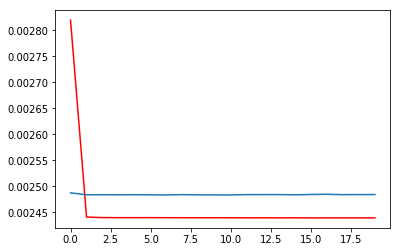

In [110]:
if mode == 'train':
     fig1 = plt.figure()
     plt.plot(hist.history['loss'],'r')
     plt.plot(hist.history['val_loss'])

In [111]:
model.load_weights('vae_cnn')

# Check for validation
for time in range(0,10):
    recoded = model.predict(swe_valid[time:time+1,:,:,:])
    true = preproc.inverse_transform(swe_valid[time:time+1,:,:,:].reshape(1,4096)).reshape(64,64)
    recoded = preproc.inverse_transform(recoded.reshape(1,4096)).reshape(64,64)

    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(6,6))
    cs1 = ax[0].imshow(true,label='input')
    cs2 = ax[1].imshow(recoded,label='decoded')

    for i in range(2):
        ax[i].set_xlabel('x')
        ax[i].set_ylabel('y')
            
    fig.colorbar(cs1,ax=ax[0],fraction=0.046, pad=0.04)
    fig.colorbar(cs2,ax=ax[1],fraction=0.046, pad=0.04)
    ax[0].set_title(r'True $q_1$')
    ax[1].set_title(r'Reconstructed $q_1$')
    plt.subplots_adjust(wspace=0.5,hspace=-0.3)
    plt.tight_layout()
    plt.show()

NameError: name 'preproc' is not defined

In [112]:
model.load_weights('vae_cnn')

#recoded = model.predict(swe_valid[time:time+1,:,:,:])

In [114]:
generator = model.predict(swe_valid[0:2])

In [115]:
print(generator.shape)

(2, 64, 64, 1)


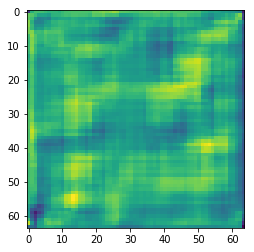

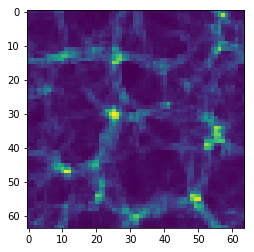

In [116]:
plt.imshow(generator[1,:,:,0])
plt.figure()
plt.imshow(swe_valid[1,:,:,0])

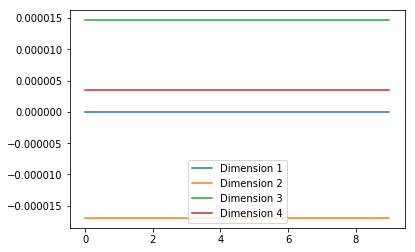

In [117]:


encoded_t_arr = K.eval(encoder(swe_train[:,:,:,:].astype('float32')))[0]
encoded_v_arr = K.eval(encoder(swe_valid[:,:,:,:].astype('float32')))[0]
encoded_t = encoded_t_arr
encoded_v = encoded_v_arr



plt.figure()
plt.plot(encoded_t[0:10,0],label='Dimension 1')
plt.plot(encoded_t[0:10,1],label='Dimension 2')
plt.plot(encoded_t[0:10,2],label='Dimension 3')
plt.plot(encoded_t[0:10,3],label='Dimension 4')
plt.legend()
plt.show()

encoded = np.concatenate((encoded_t,encoded_v),axis=0)
np.save('VAE_Coefficient_Training_Data.npy',encoded)
